In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import haversine as hs
import geopandas as gp
from shapely.geometry import MultiPoint, Point, Polygon
import numpy as np
from sklearn.cluster import KMeans

from pyomo.environ import Var, Expression, NonNegativeReals, Block, ConcreteModel, Constraint, Objective, Param, maximize, SolverFactory,RangeSet
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from pyomo.environ import Block, Expression, units as pyunits
import math
from watertap3.utils.watertap_df import watertap_setup,run_watertap3, run_and_return_model, print_results
# from watertap3.utils import watertap_setup,run_watertap3, run_and_return_model
from watertap3.utils import get_case_study

from watertap3.truck_pipe_cost_functions import pipe_costing,elevation_gain, elevation
from pyomo.util.infeasible import log_infeasible_constraints, log_infeasible_bounds

from IPython.display import clear_output

In [20]:
bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs_transport_updated_basis_1.csv')

In [3]:
contiguous_usa = ('AL','AZ','AR','CA','CO','CT','DE','FL','GA','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE',
                  'NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY','DC')

Clustering brackish water wells

In [28]:
bw_df_centroid = pd.read_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish\wi_bw_lcow_kmeans_2Nov23.csv').drop(['Unnamed: 0'],axis=1)
state_alpha ='TX'

In [25]:
# Sort in decreasing order of well yield and increasing order of distance
bw_df_centroid_1 = bw_df_centroid.sort_values(['well_yield'],ascending = False, ignore_index=True).sort_values(['dist_miles'],ignore_index=True).groupby('cluster_label')
bw_df_centroid_1 = bw_df_centroid_1.apply(pd.DataFrame)

# bw_df_centroid_1 = bw_df_centroid_1.sort_values(['dist_miles'],ignore_index=True).groupby('cluster_id')
# bw_df_centroid_1 = bw_df_centroid_1.apply(pd.DataFrame)

In [26]:
bw_df_centroid_1.head(2)

,unique_site_ID,state_alpha,county_nm,Latitude,Longitude,well_depth_ft,well_yield,TDS_kgm3,state,elec_price,...,elec_int,tds_out,well_field_o&m,well_field_cap_inv,cluster_label,centroid_long,centroid_lat,dist_miles,centroid_elev,well_elev
0,USGS-430300087581901,WI,Milwaukee,43.050015,-87.972031,1837.0,0.048579,0.770,Wisconsin,0.0731,...,3.884727,0.056248,0.218676,0.593448,0,-87.986288,43.074277,2.936008,228.538528,216.597595
1,USGS-430255088001801,WI,Milwaukee,43.048622,-88.005089,1692.0,0.025236,0.742,Wisconsin,0.0731,...,3.738203,0.059828,0.105175,0.324953,0,-87.986288,43.074277,3.235908,228.538528,199.142075


Function to create treatment train CSV s

In [7]:
# bw_df_centroid_1[bw_df_centroid_1['cluster_label']==1]

In [8]:
cols = ['state','state_elec_price','cluster_id','centroid_long','centroid_lat','centroid_elev','well_count','well_id','well_elev',
                        'latitude','longitude','well_depth','well_yield','elect_int_old','tds','dist','avg_well_yield','avg_tds']
bw_cluster_lcow = pd.DataFrame(columns=cols)

bw_df_centroid_sample = bw_df_centroid_1[bw_df_centroid_1['state_alpha'] == state_alpha]

# Iterate through each cluster id
for cl_id in bw_df_centroid_sample.cluster_label.unique():
        bw_cluster = bw_df_centroid_sample[bw_df_centroid_sample['cluster_label']==cl_id]
        # TDS 
        avg_tds = 0
        # well yield
        avg_well_yield  = 0
        well_list = []
        lat_list = []
        long_list = []
        well_depth_list = []
        well_yield_list = []
        tds_list = []
        dist_list = []
        # This is  electrical intensity in Kwh/m3
        elect_list = []

        centroid_elev_list = []
        well_elev_list = []

        well_count = 0
        # Iterate over each brackish water site within a cluster
        for well_id in bw_cluster['unique_site_ID'].unique():

                well_count = well_count + 1
                bw_cluster_well = bw_cluster[bw_cluster['unique_site_ID']==well_id]
                # Calculate average well yield
                avg_well_yield_old = avg_well_yield
                avg_well_yield = avg_well_yield + bw_cluster[bw_cluster['unique_site_ID']==well_id]['well_yield'].values[0]

                # Calculate average TDS
                avg_tds = (avg_tds*avg_well_yield_old + bw_cluster[bw_cluster['unique_site_ID']==well_id]['TDS_kgm3'].values[0] * bw_cluster[bw_cluster['unique_site_ID']==well_id]['well_yield'].values[0])/avg_well_yield
                
                well_list.append(well_id)
                lat_list.append(bw_cluster_well['Latitude'].values)
                long_list.append(bw_cluster_well['Longitude'].values)
                well_depth_list.append(bw_cluster_well['well_depth_ft'].values)
                well_yield_list.append(bw_cluster_well['well_yield'].values)
                tds_list.append(bw_cluster_well['TDS_kgm3'].values)
                dist_list.append(bw_cluster_well['dist_miles'].values)
                # centroid_elev_list.append(bw_cluster_well['centroid_elev'])
                elect_list.append(bw_cluster_well['elec_int'].values)
                well_elev_list.append(bw_cluster_well['well_elev'])

                
                # Update results table
                temp = {'state': state_alpha,
                        'state_elec_price': bw_df_centroid_sample['elec_price'].unique()[0],
                        'cluster_id': cl_id,
                        'centroid_long':bw_cluster['centroid_long'].unique()[0],
                        'centroid_lat':bw_cluster['centroid_lat'].unique()[0],
                        # 'centroid_elev': list(centroid_elev_list),
                        'centroid_elev': bw_cluster_well['centroid_elev'].unique()[0],
                        'well_count': well_count,
                        'well_id': list(well_list),
                        'well_elev': list(well_elev_list),
                        'latitude': list(lat_list),
                        'longitude': list(long_list),
                        'well_depth': list(well_depth_list),
                        'well_yield':list(well_yield_list),
                        'elect_int_old':list(elect_list),
                        'tds': list(tds_list),
                        'dist':list(dist_list),
                        'avg_well_yield': avg_well_yield,
                        'avg_tds':avg_tds
                        }
                
                temp = pd.DataFrame([temp])
                bw_cluster_lcow = pd.concat([bw_cluster_lcow,temp],ignore_index=True)
                # bw_cluster_lcow.reset_index()

bw_cluster_lcow.head(2)

,state,state_elec_price,cluster_id,centroid_long,centroid_lat,centroid_elev,well_count,well_id,well_elev,latitude,longitude,well_depth,well_yield,elect_int_old,tds,dist,avg_well_yield,avg_tds
0,CA,0.134,5,-120.121315,40.145180,1251.174927,1,[USGS-400843120071301],[[1251.174926758]],[[40.1451797]],[[-120.121315]],[[692.0]],[[0.13248942]],[[2.3991396084885084]],[[0.82]],[[0.0]],0.132489,0.8200
1,CA,0.134,8,-122.434575,38.247101,3.479558,1,[USGS-381443122254201],[[4.335468292]],[[38.245472]],[[-122.4283371]],[[821.0]],[[0.0630902]],[[2.6127207018375214]],[[1.0231004]],[[0.5740958930743217]],0.063090,1.0231


Preliminary steps to calculate treatment portion of LCOW

In [9]:
# Get relevant case study
case_study = 'big_spring'
scenario = 'dwi_a'
reference='nawi'

df1 = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/data/treatment_train_setup.csv')
df = df1[((df1.Reference == reference) & (df1.Scenario == scenario) & (df1.CaseStudy == case_study))].tail(6).copy()

desired_recovery = 1
ro_bounds = 'other'

Functions for calculating LCOW

In [12]:
def create_treatment_train(row,df):
    # well_depth = list(bw_cluster_lcow['well_depth'])
    # df_well  = pd.DataFrame(columns= df.columns)
    # print(df_well['Parameter'].get('water_type'))

    # for index,row in bw_cluster_lcow.iterrows():
    df_well  = pd.DataFrame(columns= df.columns)
    for i in range(0,len(row['well_depth'])):

        if i == 0:
                type_var = 'intake'
        else:
                type_var = 'treatment'

        if (i == len(row['well_depth']) -1 ):
                toUnit_var = 'microfiltration'
        else:
                toUnit_var = 'well_field_'+str(i+1)

        temp = {'CaseStudy':'big_spring',
                'Reference':'nawi',
                'Scenario':'dwi_a',
                'Unit':'well_field',
                'Type':type_var,
                'UnitName':'well_field_'+str(i),
                'ToUnitName': toUnit_var,
                'FromPort':'outlet',
                'Parameter':str({'water_type': ['big_spring_feed'],'lift_height': row['well_depth'][i][0],'flow_in': row['well_yield'][i][0]*3600}),
            }

        temp = pd.DataFrame([temp])
        df_well = pd.concat([df_well,temp])

    df_centroid = pd.concat([df_well,df])

    return df_centroid

def solve_treatment_train(df_centroid,avg_well_yield,avg_tds,elec_price):
    # print(avg_well_yield)
    
    m = watertap_setup(case_study=case_study, scenario=scenario, treatment_df=df_centroid)
    m = get_case_study(m=m)
    try:
        m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds, treatment_df=df_centroid)
          
        m.fs.reverse_osmosis.membrane_area.unfix()
        m.fs.reverse_osmosis.feed.pressure.unfix()

        # Updating parameters
        m.fs.big_spring_feed.flow_vol_in.fix(avg_well_yield)
        m.fs.big_spring_feed.conc_mass_in[0, 'tds'].fix(avg_tds)
        m.fs.costing_param.electricity_price = elec_price

        m = run_and_return_model(m, objective=True,print_it=True)

    except:
        # print(log_infeasible_constraints(m))
        pass
    
    return m

i = 2
print(bw_cluster_lcow.iloc[i].avg_well_yield)
df_centroid = create_treatment_train(bw_cluster_lcow.iloc[i],df)
m = solve_treatment_train(df_centroid,bw_cluster_lcow.iloc[i].avg_well_yield,bw_cluster_lcow.iloc[i].avg_tds,0.134)
# df_centroid.head()


0.0757082399999999

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD 0
WELL FIELD 1
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD 0
WELL FIELD 1
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION

.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

................

In [12]:
# Get individual well data
# bw_cluster_lcow.iloc[i]

def calc_well_lcow(well_depth, flow_in, conc, elec_price):
    case_study = 'big_spring'
    scenario = 'dwi_a'
    desired_recovery = 1
    ro_bounds = 'other' # or 'seawater'

    m = watertap_setup(case_study=case_study, scenario=scenario)
    m = get_case_study(m=m)

    # run the baseline watertap3 version of this treatment train
    m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

    m.fs.reverse_osmosis.membrane_area.unfix()
    m.fs.reverse_osmosis.feed.pressure.unfix()  

    m.fs.big_spring_feed.flow_vol_in.fix(flow_in)
    m.fs.big_spring_feed.conc_mass_in[0, 'tds'].fix(conc)
    m.fs.well_field.lift_height.fix(well_depth)
    m.fs.costing_param.electricity_price = elec_price

    m = run_and_return_model(m, objective=True,print_it=True)

    return m

n = len(bw_cluster_lcow.iloc[i].well_yield)

for k in range(0,n):
    # print(bw_cluster_lcow.iloc[i].well_yield[k][0])
    print(bw_cluster_lcow.iloc[i].well_id[k])
    well_depth = bw_cluster_lcow.iloc[i].well_depth[k][0]
    flow_in = bw_cluster_lcow.iloc[i].well_yield[k][0]
    conc = bw_cluster_lcow.iloc[i].tds[k][0]
    elec_price = 0.134

    m = calc_well_lcow(well_depth, flow_in, conc, elec_price)


USGS-381443122254201

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION

.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
..........

In [12]:
m.fs.well_field.lift_height.display()

lift_height : Lift height for well pump [ft]
    Size=1, Index=fs.time
    Key : Lower : Value : Upper    : Fixed : Stale : Domain
    0.0 :     0 : 800.0 : 100000.0 :  True :  True : NonNegativeReals


In [14]:
print(well_depth)

800.0


In [11]:
def bw_transport(row):

    bw_transport_lcow = 0
    for i in range(0,len(row['well_depth'])):
        # Calculate elevation gain
        centroid_lon = row['centroid_long']
        centroid_lat = row['centroid_lat']

        well_lon = row['longitude'][i][0]
        well_lat = row['latitude'][i][0]

        # elev_gain = elevation_gain(centroid_lat,centroid_lon,well_lat,well_lon)
        elev_gain = row['centroid_elev']- row['well_elev'][i].values[0]
        # print(elev_gain)

        if elev_gain <= 0:
            elev_gain = 1e-5
        
        # Calculate pipe lcow for each well

        dist = row['dist'][i][0]*1.6 # Converting distance from miles to km
        capacity  = row['well_yield'][i][0]*3600*24  #m3/s -> m3/day

        elec_price = row['state_elec_price']
        
        # pipe_LCOW * Volume = $
        pipe_lcow = pipe_costing(capacity, dist, elev_gain = elev_gain, electricity_rate = elec_price)*capacity
        
        bw_transport_lcow = bw_transport_lcow + pipe_lcow    

    return bw_transport_lcow

# bw_transport(bw_cluster_lcow.iloc[39])


Function to
1. Calculate well pumping cost
2. Transport cost to treatment facility
3. Brine transport cost
4. Total LCOW

In [12]:
def calc_lcow(row, df):
# Extracting variables for functions
    # well_depth = row['well_depth']
    # tds = row['tds']
    # well_yield = row['well_yield']

    avg_well_yield = row['avg_well_yield']
    avg_tds = row['avg_tds']
    elec_price = row['state_elec_price']

    # Create treatment train
    df_centroid = create_treatment_train(row,df)  
     
    # Calculate treatment lcow 
    try:
        m = solve_treatment_train(df_centroid,avg_well_yield,avg_tds,elec_price)
        treatment_lcow = m.fs.costing.LCOW()

        # Calculate brackish transport cost from well to treatment site
        bw_transport_lcow = bw_transport(row)/(avg_well_yield*3600*24*m.fs.costing.system_recovery())

        # Calculate brine transport cost
        brine_flow = m.fs.deep_well_injection.flow_vol_in[0].value*3600*24
        dist_to_dwi = 10 #km
        brine_transport_lcow = pipe_costing(brine_flow, dist_to_dwi, elev_gain = 1e-5, electricity_rate = elec_price)*(1-m.fs.costing.system_recovery())/m.fs.costing.system_recovery()
        
        if m.fs.results.solver.termination_condition in ['infeasible', 'maxIterations', 'unbounded', 'other']:
            treatment_lcow = 0
            bw_transport_lcow = 0
            brine_transport_lcow = 0
            
    except ValueError:
        treatment_lcow = 0
        bw_transport_lcow = 0
        brine_transport_lcow = 0
        
    except : 
        treatment_lcow = 0
        bw_transport_lcow = 0
        brine_transport_lcow = 0 
    
    lcow = treatment_lcow + bw_transport_lcow + brine_transport_lcow
    elect_int = m.fs.costing.electricity_intensity()
    recovery = m.fs.costing.system_recovery()*100

    return [treatment_lcow, bw_transport_lcow,brine_transport_lcow, lcow, elect_int]

# calc_lcow(bw_cluster_lcow.iloc[1],df)

Running the centroid LCOW calculations for Arizona

In [13]:
lcow_list = []
treatment_lcow_list = []
bw_transport_lcow_list = []
brine_transport_lcow_list = []
elect_int_list = []

for idx,row in bw_cluster_lcow.iterrows():
    treatment_lcow, bw_transport_lcow,brine_transport_lcow, lcow,elect_int = calc_lcow(row,df)
    # lcow,elect_int = calc_lcow(row,df)
    lcow_list.append(lcow)
    treatment_lcow_list.append(treatment_lcow)
    bw_transport_lcow_list.append(bw_transport_lcow)
    brine_transport_lcow_list.append(brine_transport_lcow)
    elect_int_list.append(elect_int)
    # clear_output(wait=True)

# print(elect_int_list)


Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD 0
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD 0
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION

.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
...........................

In [15]:
bw_cluster_lcow['total_lcow'] = lcow_list
bw_cluster_lcow['treatment_lcow'] = treatment_lcow_list
bw_cluster_lcow['bw_transport_lcow'] = bw_transport_lcow_list
bw_cluster_lcow['brine_transport_lcow'] = brine_transport_lcow_list
bw_cluster_lcow['elect_int_new'] = elect_int_list

bw_cluster_lcow.head(3)

,state,state_elec_price,cluster_id,centroid_long,centroid_lat,centroid_elev,well_count,well_id,well_elev,latitude,...,elect_int_old,tds,dist,avg_well_yield,avg_tds,total_lcow,treatment_lcow,bw_transport_lcow,brine_transport_lcow,elect_int_new
0,CA,0.134,5,-120.121315,40.145180,1251.174927,1,[USGS-400843120071301],[[1251.174926758]],[[40.1451797]],...,[[2.3991396084885084]],[[0.82]],[[0.0]],0.132489,0.820000,0.949256,0.908933,0.000000,0.040323,2.399140
1,CA,0.134,8,-122.434575,38.247101,3.479558,1,[USGS-381443122254201],[[4.335468292]],[[38.245472]],...,[[2.6127207018375214]],[[1.0231004]],[[0.5740958930743217]],0.063090,1.023100,1.196602,1.041110,0.089068,0.066425,2.612721
2,CA,0.134,8,-122.434575,38.247101,3.479558,2,"[USGS-381443122254201, USGS-381540122254701]","[[4.335468292], [10.074157715]]","[[38.245472], [38.2611656]]",...,"[[2.6127207018375214], [2.071895769159318]]","[[1.0231004], [0.5395150999999999]]","[[0.5740958930743217], [1.6153098312123817]]",0.075708,0.942503,1.245739,1.070346,0.117247,0.058147,3.056247


In [16]:
elect_int_old_list = []
elect_old_list = []
elect_new_list = []

for idx,row in bw_cluster_lcow.iterrows():
    # Units are kwh/s
    calc_elec_old =  np.multiply(row['well_yield'],row['elect_int_old'])
    calc_elec_new =  np.multiply(row['avg_well_yield'],row['elect_int_new']) 
    # print(calc_elec.sum()/sum(row['well_yield']))
    elect_int_old_list.append(calc_elec_old.sum()/sum(row['well_yield']))
    # Converting to kwh/day
    elect_old_list.append(calc_elec_old.sum())
    elect_new_list.append(calc_elec_new.sum())

bw_cluster_lcow['cum_elect_int_old']= elect_int_old_list

bw_cluster_lcow['elect_old']= elect_old_list
bw_cluster_lcow['elect_new']= elect_new_list


In [131]:
row = bw_cluster_lcow.tail(1)
# print(row['elect_int_new'].values[0])
# print(row['elect_int_old'].values[0])
print(row['well_yield'])

# print(np.multiply(row['well_yield'].values[0],row['elect_int_old'].values[0]))
# check = np.multiply(row['well_yield'].values[0],row['elect_int_old'].values[0]).sum()
# print('old',check)

# print(row['avg_well_yield'].values[0])
# print('new',row['avg_well_yield'].values[0]*row['elect_int_new'].values[0])
# # print(bw_cluster_lcow['cum_elect_int_old'].sum())
# # print(bw_cluster_lcow['elect_int_new'].sum())
# print(bw_cluster_lcow['elect_old'].sum())

321    [[0.1072533399999999], [0.0946352999999999], [...
Name: well_yield, dtype: object
321    [[0.1072533399999999], [0.0946352999999999], [...
Name: well_yield, dtype: object


In [19]:
bw_cluster_lcow.tail(5)

,state,state_elec_price,cluster_id,centroid_long,centroid_lat,centroid_elev,well_count,well_id,well_elev,latitude,...,avg_well_yield,avg_tds,total_lcow,treatment_lcow,bw_transport_lcow,brine_transport_lcow,elect_int_new,cum_elect_int_old,elect_old,elect_new
317,CA,0.134,19,-118.788444,34.196124,408.500641,5,"[USGS-341438119010501, USGS-341253119014601, U...","[[63.963191986], [43.844871521], [18.664432526...","[[34.244278], [34.2147255], [34.1958389], [34....",...,0.643520,0.845730,1.802924,1.407532,0.379084,0.016308,6.934530,[2.6863335748185406],1.728709,4.462509
318,CA,0.134,19,-118.788444,34.196124,408.500641,6,"[USGS-341438119010501, USGS-341253119014601, U...","[[63.963191986], [43.844871521], [18.664432526...","[[34.244278], [34.2147255], [34.1958389], [34....",...,0.681563,0.843711,1.870298,1.447297,0.407171,0.015829,7.249238,[2.646099029296687],1.803484,4.940816
319,CA,0.134,19,-118.788444,34.196124,408.500641,7,"[USGS-341438119010501, USGS-341253119014601, U...","[[63.963191986], [43.844871521], [18.664432526...","[[34.244278], [34.2147255], [34.1958389], [34....",...,0.807744,0.840527,1.961559,1.523856,0.423163,0.014540,7.873200,[2.5844727932556113],2.087592,6.359528
320,CA,0.134,19,-118.788444,34.196124,408.500641,8,"[USGS-341438119010501, USGS-341253119014601, U...","[[63.963191986], [43.844871521], [18.664432526...","[[34.244278], [34.2147255], [34.1958389], [34....",...,0.907111,0.831852,2.054686,1.600990,0.439989,0.013706,8.483150,[2.545580877696709],2.309124,7.695158
321,CA,0.134,19,-118.788444,34.196124,408.500641,9,"[USGS-341438119010501, USGS-341253119014601, U...","[[63.963191986], [43.844871521], [18.664432526...","[[34.244278], [34.2147255], [34.1958389], [34....",...,0.940233,0.821429,2.119609,1.622941,0.483209,0.013459,8.657668,[2.5177599918128686],2.367282,8.140227


In [20]:
# bw_cluster_lcow.to_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish\centroid_lcow_ca_23Oct23.csv')
# bw_cluster_lcow.to_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish\centroid_lcow_texas.csv')
# bw_cluster_lcow = pd.read_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish\centroid_lcow_ca_23Oct23.csv')

Plot LCOW as a function of number of wells

In [18]:
# Sorting original brackish water dataframe based on the centroid dataframe
bw_df_temp = bw_df[bw_df['state_alpha']=='TX'].reset_index()

bw_df_temp_1 = bw_df_temp.set_index('unique_site_ID')
bw_df_temp_sorted = bw_df_temp_1.reindex(index =  bw_df_centroid_1['unique_site_ID'] )
bw_df_temp_sorted = bw_df_temp_sorted.reset_index()

# Calculation total old energy

total_old_energy = bw_df_temp_sorted['well_yield']*bw_df_temp_sorted['elec_int']


In [19]:
bw_df_temp_sorted.head(2)
# bw_df_centroid_1.head(2)
# bw_cluster_lcow_temp.head(2)

,unique_site_ID,index,state_alpha,county_nm,Latitude,Longitude,well_depth_ft,well_yield,TDS_kgm3,state,...,pipe_lcow,lcow,recovery,capital,onm,elec_int,tds_out,well_field_o&m,well_field_cap_inv,well_field_lcow
0,USGS-430300087581901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USGS-430255088001801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
20   NaN
21   NaN
22   NaN
23   NaN
24   NaN
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
35   NaN
36   NaN
37   NaN
38   NaN
39   NaN
40   NaN
41   NaN
42   NaN
43   NaN
44   NaN
45   NaN
46   NaN
47   NaN
48   NaN
49   NaN
50   NaN
51   NaN
52   NaN
53   NaN
54   NaN
55   NaN
56   NaN
57   NaN
dtype: float64

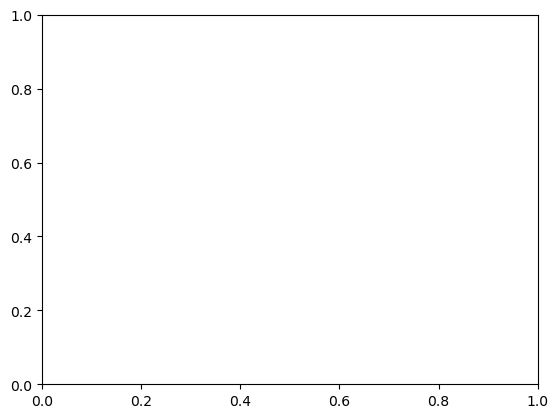

In [16]:
# Corrected plots!
bw_df_temp_sorted_1 = bw_df_temp_sorted.sort_values('lcow')
# bw_cluster_lcow_temp = bw_cluster_lcow[bw_cluster_lcow['total_lcow']!= 0]

lcow = 0
total_water = 0

fig, ax = plt.subplots()

# Calculating LCOW as a function of well yield without clustering
flow = bw_df_temp_sorted_1['well_yield']*bw_df_temp_sorted_1['recovery']/100
cum_flow = flow.cumsum()

lcow_t = bw_df_temp_sorted_1['lcow'] + bw_df_temp_sorted_1['pipe_lcow']
cost = lcow_t*flow
cum_cost = cost.cumsum()

avg_lcow = np.divide(cum_cost, cum_flow, out=np.zeros_like(cum_cost), where=cum_flow!=0) 
flow

# ax.scatter(cum_flow,avg_lcow)

# for cluster in bw_cluster_lcow_temp['cluster_id'].unique()[0:2]:
#     temp = bw_cluster_lcow_temp[bw_cluster_lcow_temp['cluster_id']==cluster]
    
#     flow = temp['avg_well_yield']*1 # Still need to add system recovery term here!!

#     # cum_flow = flow.cumsum()
#     cost_total_lcow = temp['total_lcow']*flow
#     cum_cost = cost_total_lcow.cumsum()

#     avg_lcow =  np.divide(cum_cost, flow, out=np.zeros_like(cum_cost), where=flow!=0) 
#     print(avg_lcow)

#     ax.scatter(total_water + flow, lcow + avg_lcow, s=80)

#     # if len(avg_lcow)==1:
#     #     lcow = lcow + avg_lcow
#     # else:
#     #     lcow = lcow + avg_lcow[-1]

#     total_water = total_water + temp.tail(1)['avg_well_yield'].values[0]



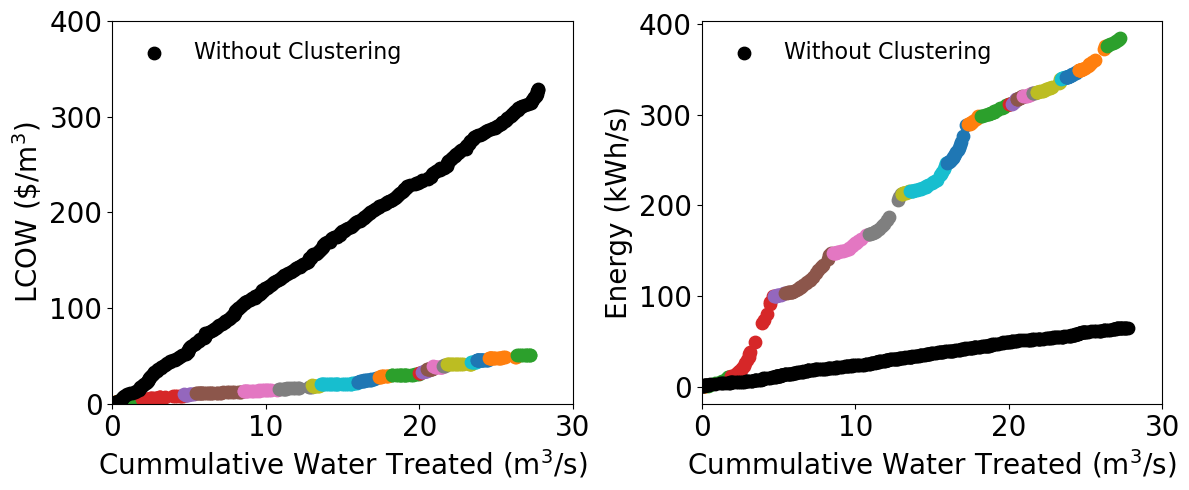

In [12]:
# Incorrect plots :(
bw_cluster_lcow_temp = bw_cluster_lcow[bw_cluster_lcow['total_lcow']!= 0]

# Column of total old energy
# total_old_energy = 

lcow = 0
total_water = 0
last_elect_int = 0

fig,(ax,ax0) = plt.subplots(1,2,figsize=(12,5))

for cluster in bw_cluster_lcow_temp['cluster_id'].unique():
    temp = bw_cluster_lcow_temp[bw_cluster_lcow_temp['cluster_id']==cluster]

    ax.scatter(total_water + temp['avg_well_yield'],lcow + temp['total_lcow'], s=80)

    ax0.scatter(total_water + temp['avg_well_yield'], last_elect_int + temp['elect_new'], s=80)
   
    lcow = lcow + temp.tail(1)['total_lcow'].values[0]
    total_water = total_water + temp.tail(1)['avg_well_yield'].values[0]
    last_elect_int = last_elect_int + temp.tail(1)['elect_new'].values[0]

    
# ax.scatter(bw_cluster_lcow.index,bw_cluster_lcow['total_lcow'])

ax.scatter(bw_df_temp_sorted['well_yield'].cumsum(),bw_df_temp_sorted['lcow'].cumsum(),label='Without Clustering',color='black',s=80)
ax0.scatter(bw_df_temp['well_yield'].cumsum(),total_old_energy.cumsum(),label='Without Clustering',color='black',s=80)

# ax0.set_ylim([0,20000])

ax.set_ylabel(r'LCOW (\$/m${^3}$)',fontsize=20)
ax0.set_ylabel(r'Energy (kWh/s)',fontsize=20)
ax.set_ylim([0,400])

for a in [ax,ax0]:
    a.set_xlabel(r'Cummulative Water Treated (m${^3}$/s)',fontsize=20)
    a.legend(facecolor = 'white',fontsize=16,frameon=False,loc='upper left')
    a.tick_params(axis='both', which='major', labelsize=20)
    a.set_xlim([0,30])

fig.tight_layout()


In [87]:
# case_study = 'big_spring'
# scenario = 'dwi_a'
# desired_recovery = 1
# ro_bounds = 'other' # or 'seawater'

# m = watertap_setup(case_study=case_study, scenario=scenario)
# m = get_case_study(m=m)

# # run the baseline watertap3 version of this treatment train
# m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

# m.fs.reverse_osmosis.membrane_area.unfix()
# m.fs.reverse_osmosis.feed.pressure.unfix()

# # Iterate over each cluster label

# bw_df_centroid_1 = bw_df_centroid[bw_df_centroid['state_alpha']=='TX']

# for centroid in bw_df_centroid_1['cluster_id'].unique():
#     bw_cluster = bw_df_centroid_1[bw_df_centroid["cluster_id"]==centroid]
    
#     # TDS 
#     avg_tds = 0
#     # well yield
#     avg_well_yield  = 0
#     # Iterate over each brackish water site within a cluster
#     for site in bw_cluster.unique_site_ID.unique():
#         # Calculate average well yield
#         avg_well_yield_old = avg_well_yield
#         avg_well_yield = avg_well_yield + bw_cluster[bw_cluster['unique_site_ID']==site]['well_yield'].values[0]

#         # Calculate average TDS
#         avg_tds = (avg_tds*avg_well_yield_old + bw_cluster[bw_cluster['unique_site_ID']==site]['TDS_kgm3'].values[0] * bw_cluster[bw_cluster['unique_site_ID']==site]['well_yield'].values[0])/avg_well_yield
        
